## Creating main dataset to standardize for the Final Jupyter Notebook

Needs to have ROI, Budgets, and Runntime

In [1]:
### Import the nessesary libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from math import sqrt

In [2]:
df_num = pd.read_csv('data/tn.movie_budgets.csv')

In [3]:
conn = sqlite3.connect('data/im.db')
q = """
SELECT 
    primary_title AS p_title,
    runtime_minutes AS time_min,
    averagerating AS avg_rating,
    genres
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
;
"""
df_IMDB = pd.read_sql(q, conn)
df_IMDB = df_IMDB.dropna()

Combine the two into a single dataframe

In [4]:
### Merge on Primary Title
df = pd.merge(df_IMDB, 
            df_num, 
            how='inner', 
            left_on = 'p_title', 
            right_on = 'movie')
#df.info()

Cleaning the dataset

In [5]:
#Domestic
df['domestic_millions'] = df.domestic_gross.str.replace(',','')
df['domestic_millions'] = df.domestic_millions.str.replace('$','')
df['domestic_millions'] = pd.to_numeric(df.domestic_millions) / 1000000

#Worldwide
df['worldwide_millions'] = df.worldwide_gross.str.replace(',','')
df['worldwide_millions'] = df.worldwide_millions.str.replace('$','')
df['worldwide_millions'] = pd.to_numeric(df.worldwide_millions) / 1000000

# Get rid of non-numerics in production_budget
df['budget_millions'] = df.production_budget.str.replace(',','')
df['budget_millions'] = df.budget_millions.str.replace('$','')
df['budget_millions'] = pd.to_numeric(df.budget_millions) / 1000000


#df.info()

In [6]:
#Drop duplicates
df.drop_duplicates(subset=['movie'], keep = 'first', inplace=True)
# df.head(10)

In [7]:
#df.info()

Adding in the correct roi

In [8]:
df['roi'] = (df.worldwide_millions - df.budget_millions)/df.budget_millions

Add in the binning for the production budget

In [9]:
def binning(x):
    if x > 216:
        return 216
    elif x > 108:
        return 108
    elif x > 64:
        return 64
    elif x > 32:
        return 32
    elif x > 16:
        return 16
    elif x > 8:
        return 8
    elif x > 4:
        return 4
    elif x > 2:
        return 2
    else:
        return 1

In [10]:
x = [binning(x) for x in df['budget_millions']]

In [11]:
pd.options.mode.chained_assignment = None
df['budget_binning'] = x

In [12]:
df.head(10)

,p_title,time_min,avg_rating,genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_millions,worldwide_millions,budget_millions,roi,budget_binning
0,Foodfight!,91.0,1.9,"Action,Animation,Comedy",26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706",0.000000,0.073706,45.0,-0.998362,32
1,On the Road,124.0,6.1,"Adventure,Drama,Romance",17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",0.720828,9.313302,25.0,-0.627468,16
4,The Secret Life of Walter Mitty,114.0,7.3,"Adventure,Comedy,Drama",37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183",58.236838,187.861183,91.0,1.064409,64
5,A Walk Among the Tombstones,114.0,6.5,"Action,Crime,Drama",67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587",26.017685,62.108587,28.0,1.218164,16
6,Jurassic World,124.0,7.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864",652.270625,1648.854864,215.0,6.669092,108
7,The Rum Diary,119.0,6.2,"Comedy,Drama",16,"Oct 28, 2011",The Rum Diary,"$45,000,000","$13,109,815","$21,544,732",13.109815,21.544732,45.0,-0.521228,32
8,The Three Stooges,92.0,5.1,"Comedy,Family",4,"Apr 13, 2012",The Three Stooges,"$30,000,000","$44,338,224","$54,052,249",44.338224,54.052249,30.0,0.801742,16
9,Anderson's Cross,98.0,5.5,"Comedy,Drama,Romance",65,"Dec 31, 2010",Anderson's Cross,"$300,000",$0,$0,0.000000,0.000000,0.3,-1.000000,1
10,Tangled,100.0,7.8,"Adventure,Animation,Comedy",15,"Nov 24, 2010",Tangled,"$260,000,000","$200,821,936","$586,477,240",200.821936,586.477240,260.0,1.255682,216
11,John Carter,132.0,6.6,"Action,Adventure,Sci-Fi",14,"Mar 9, 2012",John Carter,"$275,000,000","$73,058,679","$282,778,100",73.058679,282.778100,275.0,0.028284,216


# Genre Z-Test Analysis

In [13]:
myList = df['genres'].tolist()
genre_list=[]
for i in range(len(myList)):
    genre_list.append(myList[i].split(','))
#genre_list

In [14]:
from itertools import chain
genres=list(set(chain(*genre_list)))
#print(genres)
#print(len(genres))
#print(type(genres))

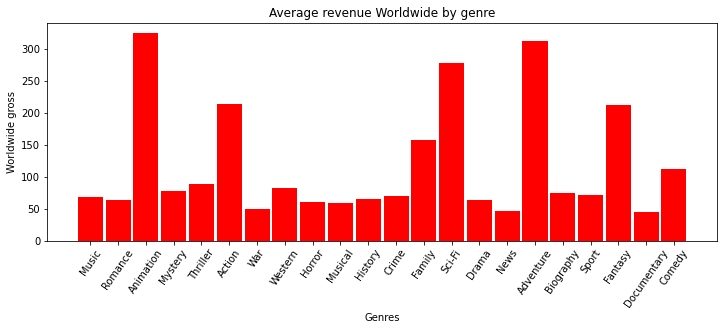

In [15]:
#Worldwide gross Average profits.
wwg_avg=[] 
for i in range(len(genres)):
    wwg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_avg.append(df['worldwide_millions'][wwg].mean())
    
fig = plt.figure(figsize = (12, 4))
 
# creating the bar plot
plt.bar(genres, wwg_avg, color = 'red',width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Worldwide gross")
plt.title("Average revenue Worldwide by genre")
plt.show()

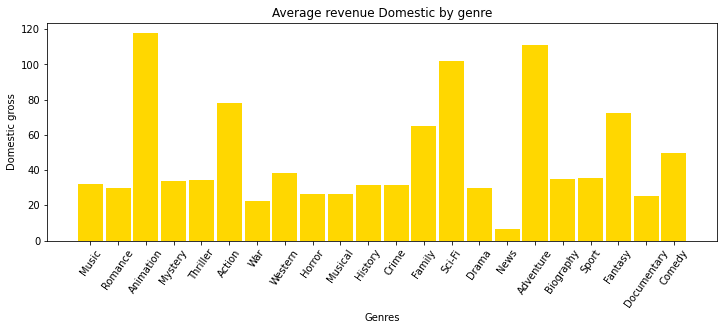

In [16]:
#Domestic gross Average profits.
dg_avg=[]
for i in range(len(genres)):
    dg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    dg_avg.append(df['domestic_millions'][dg].mean())
#dg_avg

fig = plt.figure(figsize = (12, 4))
plt.bar(genres, dg_avg, color='gold' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Domestic gross")
plt.title("Average revenue Domestic by genre")
plt.show()

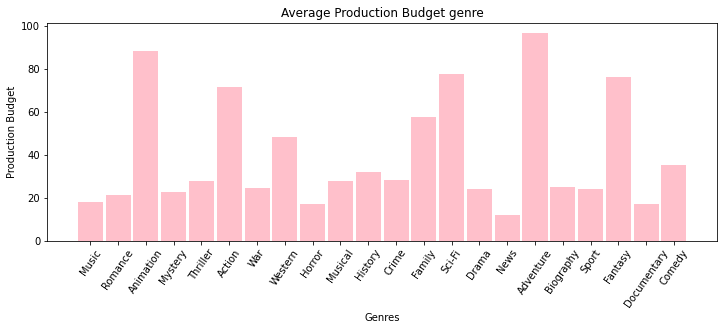

In [17]:
#production_budget Average profits.
pb_avg=[]
for i in range(len(genres)):
    pb = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    pb_avg.append(df['budget_millions'][pb].mean())
#print(pb_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, pb_avg, color='pink' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Production Budget")
plt.title("Average Production Budget genre")
plt.show()

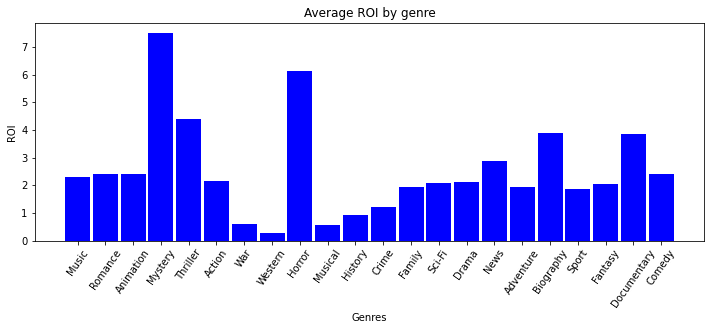

In [18]:
#Roi Average profits.
roi_avg=[]
for i in range(len(genres)):
    roi = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    roi_avg.append(df['roi'][roi].mean())
#print(roi_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, roi_avg, color='blue' ,width = 0.9)

plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("ROI")
plt.title("Average ROI by genre")
plt.show()

## Hypothesis Testing

Our team wanted to see if Mystery, Horror and Thriller movies generete a larger ROI than other genres.

### State our Hypotheses:
H-Alt -> The average ROI for Mystery, Horror and Thriller is higher than other movies  $$\large H_a\text{:   }\mu < \bar{x}$$

H-Null -> There is no difference in the ROI for Mystery, , Horror and Thriller vs. other movies  $$\large H_o\text{:   }\mu \geq \bar{x}$$

Alpha: 0.05

In [19]:
df.describe()

,time_min,avg_rating,id,domestic_millions,worldwide_millions,budget_millions,roi,budget_binning
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,103.979924,6.232744,50.559751,46.467333,113.635795,37.388168,2.650609,26.987572
std,18.837816,1.132598,28.536296,77.744015,215.193088,51.319530,13.732268,36.996243
min,5.000000,1.600000,1.000000,0.000000,0.000000,0.001400,-1.000000,1.000000
25%,91.000000,5.600000,26.000000,0.631483,2.476599,5.000000,-0.638296,4.000000
50%,102.000000,6.300000,50.000000,18.837514,33.052520,19.000000,0.691975,16.000000
75%,114.000000,7.000000,75.000000,56.442063,116.289721,45.000000,2.655065,32.000000
max,180.000000,9.200000,100.000000,760.507625,2776.345279,425.000000,415.564740,216.000000


In [20]:
#population mean and std

roi_mean = df['roi'].mean()
roi_std = df['roi'].std()

stats.norm(roi_mean, roi_std)
plt.style.use('seaborn')

In [21]:
#Mystery mean
df_mystery = df[df['genres'].str.contains('Mystery')]
mystery_mean = df_mystery['roi'].mean()
#df_mystery
#print(mystery_mean)

#Horror mean
df_horror = df[df['genres'].str.contains('Horror')]
horror_mean = df_horror['roi'].mean()
#df_mystery
#print(mystery_mean)

#Thriller mean
df_thriller = df[df['genres'].str.contains('Thriller')]
thriller_mean = df_thriller['roi'].mean()
#df_mystery
#print(mystery_mean)

#Biography mean
df_Biography = df[df['genres'].str.contains('Biography')]
Biography_mean = df_Biography['roi'].mean()
#df_mystery
#print(mystery_mean)

In [22]:
# Z score Function

def Zscore(Dataframe, mean):
    x_bar= mean
    n =  len(Dataframe.id)
    sigma = roi_std
    mu = roi_mean
    z = (x_bar - mu)/(sigma/sqrt(n))

    pval= 1-stats.norm.cdf(z)
    print(f'P-value: {pval}') 
    print(pval<0.05)
    print(f'Percent area under the curve from Zscore of {z} is {stats.norm.cdf(z)*100}% \n')
   
    
Zscore(df_mystery, mystery_mean)
Zscore(df_horror, horror_mean)
Zscore(df_thriller, thriller_mean)
Zscore(df_Biography, Biography_mean)

P-value: 2.6179224713596128e-06
True
Percent area under the curve from Zscore of 4.555108887058692 is 99.99973820775287% 

P-value: 1.8842501502303044e-05
True
Percent area under the curve from Zscore of 4.121233011735249 is 99.99811574984977% 

P-value: 0.007801558342143355
True
Percent area under the curve from Zscore of 2.418069025110882 is 99.21984416578566% 

P-value: 0.11891776733913628
False
Percent area under the curve from Zscore of 1.180414155426399 is 88.10822326608637% 



# Law of Diminishing Returns Analysis

# Runtime Analysis